In [129]:
%matplotlib inline

import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from matplotlib import pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve
from sklearn.metrics import r2_score, mean_squared_error
from joblib import load

from umda.data import load_data, load_pipeline
from umda.training import get_bootstrap_samples
from umda import paths

plt.style.use("publication.mpl")

In [3]:
tmc1_df = load_data()[-1]

In [59]:
Y = np.log10(tmc1_df["Column density (cm^-2)"]).values

In [49]:
def count_atoms(mol, symbol: str) -> int:
    counter = 0
    return len([atom for atom in mol.GetAtoms() if atom.GetSymbol() == symbol])


def average_bond_order(mol) -> float:
    return np.mean([bond.GetBondTypeAsDouble() for bond in mol.GetBonds()])


def featurize_smiles(smi: str):
    mol = Chem.MolFromSmiles(smi, sanitize=False)
    # makes sure that rdkit has stuff to work with
    mol.UpdatePropertyCache(strict=False)
    Chem.GetSymmSSSR(mol)
    atom_num = mol.GetNumAtoms()
    heavy_num = Descriptors.HeavyAtomCount(mol)
    bond_num = mol.GetNumBonds()
    mol_weight = Descriptors.MolWt(mol)
    num_rings = mol.GetRingInfo().NumRings()
    avg_bond_order = average_bond_order(mol)
    valence_electrons = Descriptors.NumValenceElectrons(mol)
    # atom counting features
    atom_counts = [count_atoms(mol, symbol) for symbol in ["C", "O", "N", "S", "P"]]
    features = [atom_num, bond_num, mol_weight, avg_bond_order, num_rings, valence_electrons]
    features.extend([descriptor(mol) for descriptor in [Descriptors.FpDensityMorgan1, Descriptors.FpDensityMorgan2, Descriptors.FpDensityMorgan3]])
    features.extend(atom_counts)
    return features

## Generate hand picked vectors

In [50]:
hand_vecs = np.asarray([featurize_smiles(smi) for smi in tmc1_df["SMILES"]])
# replace NaNs with 0
hand_vecs[np.isnan(hand_vecs)] = 0.

/home/kelvin/miniconda3/envs/umda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/kelvin/miniconda3/envs/umda/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Grab the mol2vec vectors

In [93]:
embedder = load_pipeline()

In [94]:
mol_vecs = np.asarray([embedder.vectorize(smi) for smi in tmc1_df["SMILES"]])

In [175]:
boot_mol_X, boot_mol_Y = get_bootstrap_samples((mol_vecs, Y), n_samples=400, seed=1569016)

In [176]:
boot_hand_X, boot_hand_Y = get_bootstrap_samples((hand_vecs, Y), n_samples=400, seed=1569016)

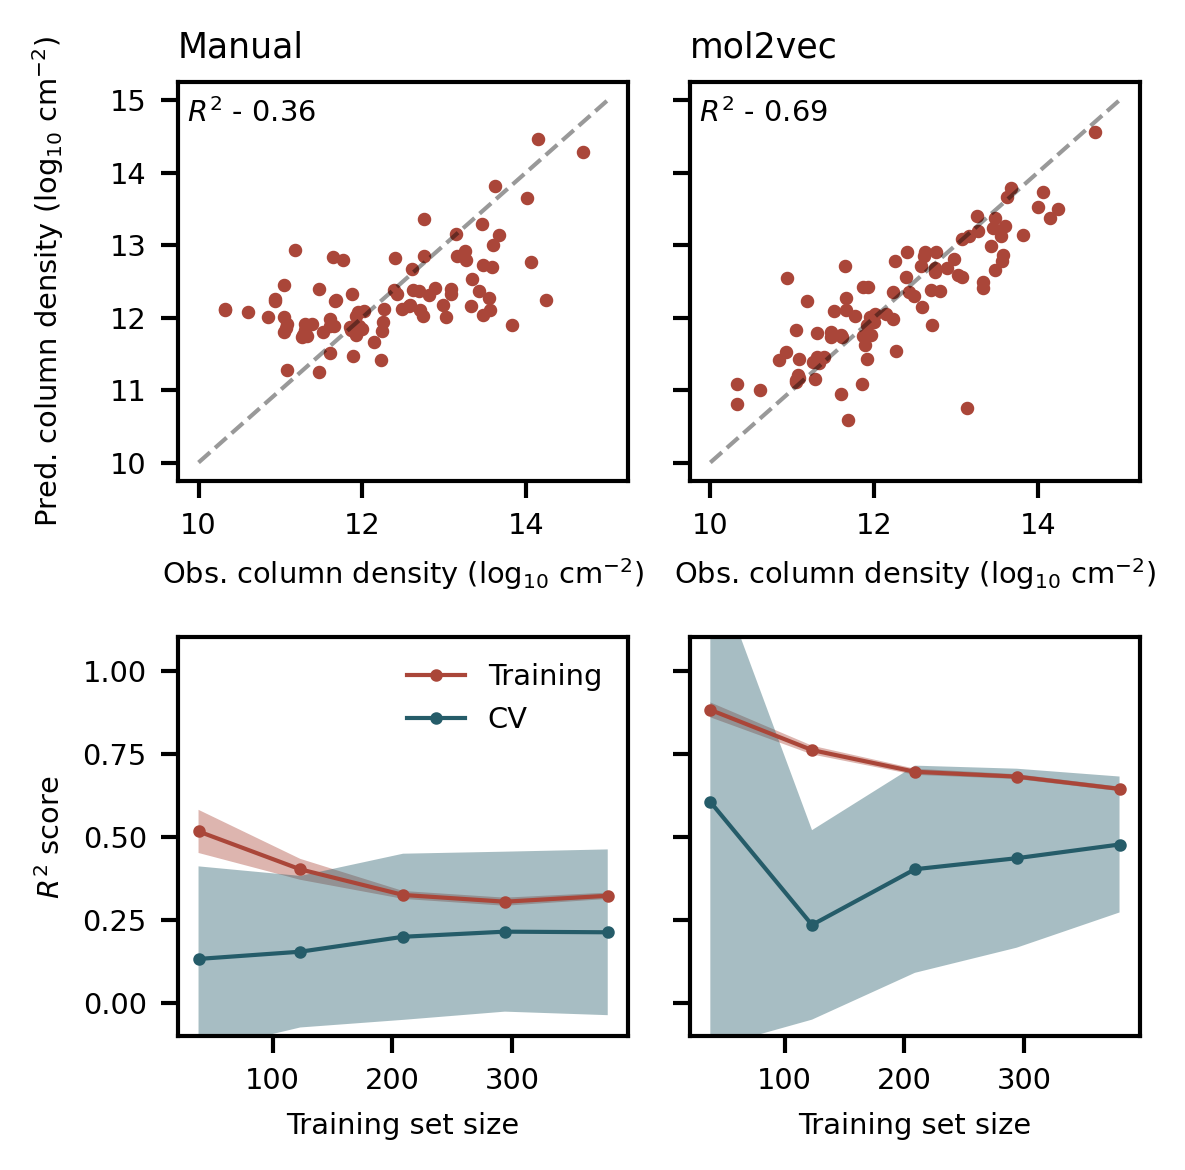

In [185]:
fig, axarray = plt.subplots(2, 2, figsize=(4, 4), sharey='row', sharex="row")

for label, axpair, data in zip(["Manual", "mol2vec"], axarray.T, [(boot_hand_X, boot_hand_Y, hand_vecs), (boot_mol_X, boot_mol_Y, mol_vecs)]):
    perf_ax, lc_ax = axpair
    model = Ridge(alpha=1e-1)
    result = model.fit(data[0], data[1])
    pred_Y = result.predict(data[2])
    r2 = r2_score(Y, pred_Y)
    perf_ax.scatter(Y, pred_Y, s=5)
    perf_ax.plot(np.arange(10, 16), np.arange(10, 16), ls="--", color="k", alpha=0.4)
    perf_ax.set_title(label, loc="left")
    perf_ax.text(0.02, 0.9, f"$R^2$ - {r2:.2f}", fontsize="x-small", transform=perf_ax.transAxes)
    # now do the learning curves
    train_sizes, train_scores, valid_scores = learning_curve(model, data[0], data[1], cv=20, scoring="r2")
    mean_train, std_train = np.abs(train_scores.mean(axis=1)), train_scores.std(axis=1)
    mean_val, std_val = np.abs(valid_scores.mean(axis=1)), valid_scores.std(axis=1)
    for target, (mean, std) in zip(["Training", "CV"], [(mean_train, std_train), (mean_val, std_val)]):
        lc_ax.plot(train_sizes, mean, marker="o", label=target, markersize=2.)
        lc_ax.fill_between(train_sizes, mean + std, mean - std, alpha=0.4)
        lc_ax.set(ylim=[-0.1, 1.1])
    if label == "Manual":
        perf_ax.set(ylabel="Pred. column density ($\log_{10}$ cm$^{-2}$)")
        lc_ax.set(ylabel="$R^2$ score")
        lc_ax.legend(fontsize="x-small", loc=1)
    perf_ax.set_xlabel("Obs. column density ($\log_{10}$ cm$^{-2}$)", fontsize="x-small")
    lc_ax.set_xlabel("Training set size")
fig.align_labels()
fig.savefig("outputs/ridge_handpicked_vs_mol2vec.pdf", dpi=150)